In [1]:
from functools import partial
from multiprocessing import Pool
from os.path import join
from pathlib import Path
import random

In [2]:
import pandas as pd
import numpy as np
import PIL.Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [47]:
from torch.utils.data import Dataset
import torch
from torchvision import transforms as T
from torchvision.transforms.functional import to_tensor, to_pil_image
from fastai.vision import open_image, Image, ImagePoints, FlowField, ImageItemList
from fastai.vision.transform import (
    rotate,
    flip_lr,
    perspective_warp,
    symmetric_warp,
    rand_zoom,
    rand_crop
)

In [48]:
seed = 1
random.seed(seed)
torch.manual_seed(seed)

In [49]:
ROOT = Path.home()/'data'/'landmarks'/'all'

In [50]:
!ls $ROOT

300W  afw  helen  ibug	lfpw


In [51]:
def gather_files(root):
    images = []
    for ext in ('jpeg', 'jpg', 'JPEG', 'JPG', 'png', 'PNG'):
        for filename in root.glob(f'**/*.{ext}'):
            images.append(filename)
    
    points = {}
    for ext in ('pts', 'PTS'):
        for filename in root.glob(f'**/*.{ext}'):
            uid = str(filename.parent / filename.stem)
            points[uid] = filename.relative_to(root)
        
    records = []
    for i, image_file in enumerate(images):
        uid = str(image_file.parent / image_file.stem)
        if uid not in points:
            print(f'Warning: image file {image_file} doesn\'t have landmarks file')
            continue
        rel_path = image_file.relative_to(root)
        records.append({
            'uid': i, 
            'subset': str(rel_path.parts[0]),
            'image': str(rel_path), 
            'points': str(points[uid])})
        
    df = pd.DataFrame(records, columns=['uid', 'subset', 'image', 'points'])
    df.set_index('uid', inplace=True)
    return df

In [52]:
index = gather_files(ROOT)

In [53]:
index.sample(5)

,subset,image,points
uid,,,
3700,lfpw,lfpw/trainset/image_0673.png,lfpw/trainset/image_0673.pts
866,helen,helen/trainset/2609134545_1.jpg,helen/trainset/2609134545_1.pts
3833,lfpw,lfpw/trainset/image_0164.png,lfpw/trainset/image_0164.pts
57,ibug,ibug/image_108.jpg,ibug/image_108.pts
1892,helen,helen/trainset/2432515626_1.jpg,helen/trainset/2432515626_1.pts


In [54]:
def read_landmarks(filename):
    """Reads file with landmarks information.

    A helper utility to strip the non-relevant content from the .PTS files 
    and read landmarks as two numpy arrays.
    """
    with open(filename, 'r') as file:
        lines = [line.strip() for line in file]

    line = lines[0]
    while not line.startswith('{'):
        line = lines.pop(0)

    xs, ys = [], []
    for line in lines:
        if line.strip().startswith('}'):
            continue
        x, y = line.split()[:2]
        xs.append(x)
        ys.append(y)

    xs = np.array(xs, dtype=np.float) - 1
    ys = np.array(ys, dtype=np.float) - 1
    return xs, ys

In [55]:
class DatasetViewer:
    
    def __init__(self, root, index):
        self.root = root
        self.index = index
    
    def preview_random(self, dataset=None, n=3, **fig_kwargs):
        df = self.index
        if dataset is not None:
            df = self.index[self.index.subset == dataset]
        samples = df.sample(n ** 2)
        if not fig_kwargs:
            fig_kwargs = {'figsize': (10, 10)}
        f, axes = plt.subplots(n, n, **fig_kwargs)
        for (_, record), ax in zip(samples.iterrows(), axes.flat):
            self.preview_image_with_landmarks(record.name, ax=ax)
            ax.set_title(record.name)
    
    def preview_image_with_landmarks(self, uid, ax=None, return_value=False):
        """Shows a single image from traning dataset with landmarks plotted above."""
    
        record = self.index.loc[uid]
        image_path = join(self.root, record.image)
        points_path = join(self.root, record.points)
        img = PIL.Image.open(image_path)
        cmap = 'gray' if len(img.size) == 2 else None
        xs, ys = read_landmarks(points_path)

        if ax is None:
            fig = plt.figure(figsize=(12, 10))
            ax = fig.add_subplot(111)

        ax.scatter(xs, ys, c='darkorange', edgecolor='white', alpha=0.6)
        ax.imshow(img, cmap=cmap)
        ax.set_axis_off()
        
        if return_value:
            return ax   

In [58]:
viewer = DatasetViewer(ROOT, index)

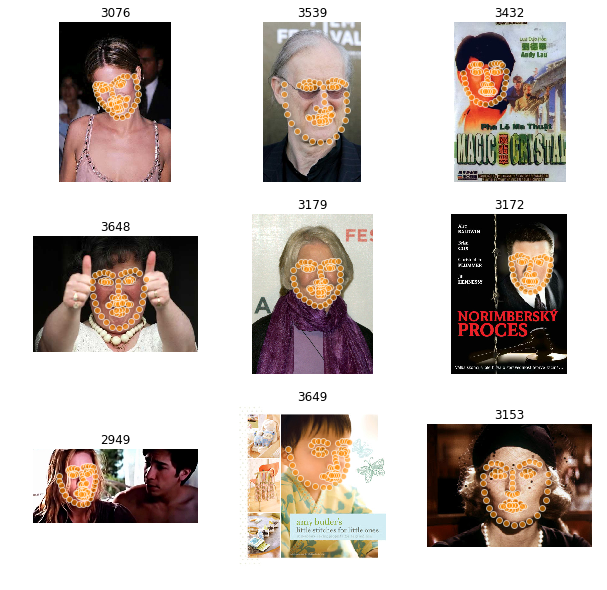

In [59]:
viewer.preview_random('lfpw')

In [68]:
def generate_dataset(root, index, output, pad=5):
    root = Path(root).expanduser()
    path = Path(output).expanduser()

    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
        
    (path/'images').mkdir(exist_ok=True)
    (path/'points').mkdir(exist_ok=True)
    
    worker = partial(process_record, root, path, pad)
    
    with Pool() as pool:
        pool.map(worker, enumerate(index.to_dict(orient='records')))


def process_record(src, dst, pad, args):
    i, record = args
    img = PIL.Image.open(src/record['image'])
    pts = read_landmarks(src/record['points'])
    new_img, (xs, ys) = crop_landmarks(img, pts, pad)
    landmarks = np.c_[ys, xs]
    new_img.save(dst/'images'/f'{i}.png', format='PNG')
    np.savetxt(dst/'points'/f'{i}.txt', landmarks, fmt='%.4f', delimiter=',')


def crop_landmarks(pil_image, landmarks, pad=None, scale='fastai'):
    if scale not in ('fastai', 'relative', 'asis'):
        scale = 'asis'
        
    xs, ys = landmarks
    left, right = xs.min(), xs.max()
    top, bottom = ys.min(), ys.max()
    
    if pad is not None:
        left -= pad
        right += pad
        top -= pad
        bottom += pad
        
    cropped = pil_image.crop((left, top, right, bottom))
    xs -= left
    ys -= top
    w, h = (right - left), (bottom - top)
    
    if scale == 'relative':
        xs /= w
        ys /= h
    elif scale == 'fastai':
        xs = 2*xs/w - 1
        ys = 2*ys/h - 1
    
    return cropped, (xs, ys)

In [69]:
DATA = Path.home()/'data'/'landmarks'/'prepared'

In [70]:
generate_dataset(ROOT, index, DATA, pad=10)

In [71]:
n = len(list((DATA/'images').iterdir()))

In [72]:
trn_idx, val_idx = train_test_split(np.arange(n), test_size=0.1)

In [108]:
class FaceLandmarks:
    
    def __init__(self, folder, indicies=None, transforms=None):
        folder = Path(folder).expanduser()
        images = read_enumerated_files(folder/'images')
        points = read_enumerated_files(folder/'points')

        images, points = zip(*[
            (str(x), str(y))
            for i, (x, y) in enumerate(zip(images, points)) 
            if indicies is not None and i in indicies])
        
        self.images = images
        self.points = points
    
    def __getitem__(self, item):
        img = open_image(self.images[item])
        pts = torch.FloatTensor(np.loadtxt(self.points[item], delimiter=','))
        pts = ImagePoints(FlowField(img.size, pts), scale=False)
        return img, pts
    
    def __len__(self):
        return len(self.images)
    
    def show(self, i, **fig_kwargs):
        img, pts = self[i]
        n = len(pts)
        xs, ys = pts[:n//2], pts[n//2:]
        f, ax = plt.subplots(1, 1, **fig_kwargs)
        width, height = img.size
        xs *= width
        ys *= height
        ax.imshow(img)
        ax.set_axis_off()
        ax.scatter(xs, ys, edgecolor='white', color='darkorange', alpha=0.8)

In [ ]:
class AugmentationGroup:
    pass
    

In [111]:
from dataclasses import dataclass

In [ ]:
@dataclass
class Rotate:
    affine = True
    
    @property
    def matrix(self):
        pass

In [97]:
def read_enumerated_files(folder):
    return [str(x) for x in sorted(
        list(folder.iterdir()), 
        key=lambda path: int(path.stem))]

In [98]:
trn_ds = FaceLandmarks(DATA, indicies=trn_idx)
val_ds = FaceLandmarks(DATA, indicies=val_idx)

In [107]:
torch.FloatTensor(np.loadtxt(trn_ds.points[0], delimiter=','))

tensor([[-0.7331, -0.5802],
        [-0.5124, -0.6562],
        [-0.3339, -0.7041],
        [-0.1440, -0.7365],
        [ 0.0449, -0.7405],
        [ 0.2318, -0.6962],
        [ 0.3784, -0.6084],
        [ 0.5462, -0.5641],
        [ 0.6829, -0.4578],
        [ 0.7331, -0.2749],
        [ 0.6594, -0.1186],
        [ 0.6126,  0.0755],
        [ 0.5355,  0.2644],
        [ 0.4071,  0.4014],
        [ 0.2062,  0.5234],
        [-0.0254,  0.6253],
        [-0.2906,  0.7405],
        [-0.5285, -0.5846],
        [-0.4683, -0.4976],
        [-0.3753, -0.4138],
        [-0.2838, -0.3241],
        [-0.1897, -0.2269],
        [-0.1207, -0.0211],
        [-0.1204,  0.0922],
        [-0.1138,  0.2210],
        [-0.1069,  0.3307],
        [-0.0839,  0.4306],
        [-0.0813, -0.1849],
        [ 0.0379, -0.2326],
        [ 0.1441, -0.2813],
        [ 0.2707, -0.3364],
        [ 0.2160, -0.4203],
        [ 0.2856, -0.4098],
        [ 0.3436, -0.3619],
        [ 0.3436, -0.2733],
        [ 0.3399, -0

In [109]:
face, landmarks = trn_ds[0]

RuntimeError: expected type torch.DoubleTensor but got torch.FloatTensor

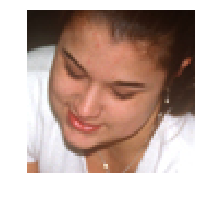

In [110]:
face.show(y=landmarks)

In [36]:
img = PIL.Image.open('/home/ck/data/landmarks/all/lfpw/trainset/image_0001.png')
pts = read_landmarks('/home/ck/data/landmarks/all/lfpw/trainset/image_0001.pts')